# Example: MMS Price Convergence

This is an example of how to obtain AEMO's MMS data, and query it.
This is part of my [Guide to MMS Data](https://www.mdavis.xyz/mms-guide/). Read that for the context and explanation.

This example looks at the convergence of AEMO's price forecasts.

You need to configure `data_directory` and `results_directory`.

## Imports

In [7]:
import os
import datetime as dt
from zipfile import ZipFile
from urllib3.util.retry import Retry
from urllib.parse import unquote
from time import sleep

import requests
import polars as pl
import polars.selectors as cs

## Configuration and Constants

In [2]:
# customize for yourself
data_directory = '/home/matthew/Data/price-convergence'

# AEMO's zips and CSVs
# If doing many projects with AEMO data, point to the same directory to avoid re-downloading files
raw_directory = os.path.join(data_directory, '01-nemosis')

preprocessed_directory = os.path.join(os.path.dirname(data_directory), '02-preprocessed') # parquet of tables
results_directory = os.path.join(os.path.dirname(data_directory), '03-results')
result_path = os.path.join(results_directory, "results.parquet")

# which timespan to look at
# List of (year, month)
# 12 months in the past, from time of writing
months = [(2024, 11), (2024, 12)] + [(2025, m) for m in range(1, 10+1)]


hrs_per_interval = 5 / 60 # 5 minute intervals
frac_threshold = 0.5

dt_fmt = "%Y/%m/%d %H:%M:%S"

In [3]:
for d in [data_directory, preprocessed_directory, results_directory]:
    os.makedirs(d, exist_ok=True)

## Download Zipped CSVs

In [4]:
# reuse a session to be faster
session = requests.session()

# define retry behavior
# 403 is unusual for a retry config, 
# but nemweb sometimes gives this as a throttling signal
retries = Retry(
    total=4,
    backoff_factor=2,
    status_forcelist=[403, 429, 500, 502, 503, 504], 
    allowed_methods=["HEAD", "GET", "OPTIONS"]
)
adapter = requests.adapters.HTTPAdapter(max_retries=retries)
for protocol in ['http://', 'https://']:
    session.mount(protocol, adapter)

In [10]:
def download_file(url, retries=3):
    fname = unquote(url.split('/')[-1]) # unquote() to convert "%23" to "#"
    path = os.path.join(raw_directory, fname)

    # if file already exists,
    # check the file size matches what we expect
    # If so, skip the download
    if os.path.exists(path):
        head_response = session.head(url)
        head_response.raise_for_status()
        local_size = os.path.getsize(path)
        remote_size = int(head_response.headers.get('content-length', local_size))
        
        if remote_size == local_size:
            print(f"File {path.split('/')[-1]} already downloaded")
            return path
        else:
            print(f"File size mismatch, {remote_size=} != {local_size=}, redownloading {url} to {path}")
            os.remove(path)
    else:
        print(f"Downloading {url} to {path}")
        
    response = session.get(url, stream=True) 
    response.raise_for_status()

    try:
        
        # stream to disk, since these files may be larger than memory
        with open(path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=2**24):
                if chunk:
                    f.write(chunk)
    except requests.exceptions.HTTPError:
        # Already handled by session retry config
        
        # tidy up incomplete file
        if os.path.exists(path):
            os.remove(path)
        raise
    except requests.exceptions.RequestException as e:
        # this isn't caught by the session's retry configs
        
        # tidy up incomplete file
        if os.path.exists(path):
            os.remove(path)
        
        if retries > 0:
            print("Streaming error, retrying")
            sleep(6 / retries)
            return download_file(url, retries=retries - 1)
        else:
            raise
    except Exception:
        # tidy up incomplete file
        if os.path.exists(path):
            os.remove(path)
        raise
    else:
        assert os.path.exists(path), f"{path=} does not exist after downloading {url}" # temporary debugging
    return path

zips = {}
for table in ["DISPATCHPRICE", "P5MIN_REGIONSOLUTION", "PREDISPATCHPRICE"]:
    zips[table] = []
    for (year, month) in months:
        # Note that the filename is slightly different for older files
        # e.g. PUBLIC_DVD_DISPATCHPRICE_202202010000.zip

        
        url = (
            f"https://www.nemweb.com.au/Data_Archive/Wholesale_Electricity/"
            f"MMSDM/{year}/MMSDM_{year}_{month:02}/MMSDM_Historical_Data_SQLLoader"
        )

        # The PREDISPATCHPRICE data in DATA/ is a subset
        # the one in PREDISP_ALL_DATA is the full (huge) file
        if table.startswith("PREDISPATCH"):
            url += f"/PREDISP_ALL_DATA/PUBLIC_ARCHIVE%23PREDISPATCHPRICE%23ALL%23FILE01%23{year}{month:02}010000.zip"
        else:
            url += f"/DATA/PUBLIC_ARCHIVE%23{table}%23FILE01%23{year}{month:02}010000.zip"
        
        fname = url.split('/')[-1]
        path = download_file(url)
        zips[table].append(path)

File PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202411010000.zip already downloaded
File PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202412010000.zip already downloaded
File PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202501010000.zip already downloaded
File PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202502010000.zip already downloaded
File PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202503010000.zip already downloaded
File PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202504010000.zip already downloaded
File PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202505010000.zip already downloaded
File PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202506010000.zip already downloaded
File PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202507010000.zip already downloaded
File PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202508010000.zip already downloaded
File PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202509010000.zip already downloaded
File PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202510010000.zip already downloaded
File PUBLIC_ARCHIVE#P5MIN_REGIONSOLUTION#FILE01#202411010000.zip already dow

## Unzip CSVs

In [11]:
csvs = {}
for (table, zip_paths) in zips.items():
    csvs[table] = []
    for zip_path in zip_paths:
        with ZipFile(zip_path, 'r') as zf:
            for csv_name in zf.namelist():
                assert '/' not in csv_name, f"Unexpected zip member: {csv_name}"
                assert csv_name.endswith('.CSV'), f"Unexpected zip member: {csv_name}"
                csv_path = os.path.join(data_directory, csv_name)
                if not os.path.exists(csv_path): # do not re-extract
                    print(f"Unzipping {zip_path}:{csv_name}")
                    try:
                        # Second argument is the dest directory, not path
                        # If you pass a .CSV string (csv_path), it will create that as a dir, 
                        # and put a CSV inside it
                        zf.extract(csv_name, data_directory)
                    except Exception:
                        # tidy up incomplete file
                        if os.path.exists(csv_path):
                            os.remove(csv_path)
                        raise
                    else:
                        assert os.path.exists(csv_path)
                csvs[table].append(csv_path)

Unzipping /home/matthew/Data/price-convergence/01-nemosis/PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202411010000.zip:PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202411010000.CSV
Unzipping /home/matthew/Data/price-convergence/01-nemosis/PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202412010000.zip:PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202412010000.CSV
Unzipping /home/matthew/Data/price-convergence/01-nemosis/PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202503010000.zip:PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202503010000.CSV
Unzipping /home/matthew/Data/price-convergence/01-nemosis/PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202504010000.zip:PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202504010000.CSV
Unzipping /home/matthew/Data/price-convergence/01-nemosis/PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202505010000.zip:PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202505010000.CSV
Unzipping /home/matthew/Data/price-convergence/01-nemosis/PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202506010000.zip:PUBLIC_ARCHIVE#DISPATCHPRICE#FILE01#202506010000.CSV
Unzipping /home/

## Convert CSVs to Parquet

Convert the CSVs to Parquet.

Normally I do minimal work here, because this step is slow.
Do not query at this point. Just parse timestamps, drop columns etc

In [14]:
# Normally I include all columns, but some of these tables are large.
# So here I only include the columns we need, or think we _might_ need
schemas = {
    "DISPATCHPRICE": {
        "INTERVENTION": pl.Boolean(),
        "REGIONID": pl.String(), 
        "SETTLEMENTDATE": pl.Datetime(),
        "LASTCHANGED": pl.Datetime(),
        "RRP": pl.Float64()
    },
    "P5MIN_REGIONSOLUTION": {
        "INTERVAL_DATETIME": pl.Datetime(),
        "REGIONID": pl.String(),
        "RUN_DATETIME": pl.Datetime(),
        "LASTCHANGED": pl.Datetime(),
        "RRP": pl.Float64(),
    },
    "PREDISPATCHPRICE": {
        "DATETIME": pl.Datetime(),
        "REGIONID": pl.String(),
        "LASTCHANGED": pl.Datetime(),
        "INTERVENTION": pl.Boolean(),
        "RRP": pl.Float64(),
    }
}

pqs = {} # parquet files
for (table, csv_paths) in csvs.items():
    print(f"Processing {table}")
    pq_path = os.path.join(preprocessed_directory, table + ".parquet")
    pqs[table] = pq_path
    pq_schema = schemas[table]

    
    dt_cols = []
    bool_cols = []
    csv_schema = {}
    for (t, pq_type) in pq_schema.items():
        if pq_type == pl.Datetime():
            # Polars cannot read Datetime from a CSV
            # tell it those columns are strings,
            # then convert later
            csv_type = pl.String()
            dt_cols.append(t)
        elif pq_type == pl.Boolean():
            # Polars scan_csv cannot convert 0/1 to Boolean
            # so use UInt8 and convert later
            csv_type = pl.UInt8()
            bool_cols.append(t)
        else:
            csv_type = pq_type
        csv_schema[t] = csv_type

    # In theory we could past a list of file paths to scan_csv
    # In practice, we often get errors because scan_csv can't merge schemas well.
    # So read each file separately, then concat
    lfs = []
    for csv_path in csv_paths:
        lf = (
            pl.scan_csv(
            csv_path,
                skip_rows=1, # skip the header
                comment_prefix='C,"END OF REPORT",', # skip the footer
                infer_schema=False,
                schema_overrides=csv_schema,
            )
            .select(~cs.by_index(range(4))) # drop metadata columns
        )
        lfs.append(lf)
        
    lf = (
        pl.concat(lfs, how="diagonal_relaxed")
        .cast({c:pl.Boolean() for c in bool_cols}) # convert 0/1 to bool now
        # parse datetimes now
        .with_columns(
            pl.col(dt_cols).str.strptime(pl.Datetime(time_unit="ms"), format=dt_fmt)
        )
    )
    
    try:
        lf.sink_parquet(pq_path)
    except Exception:
        # tidy up incomplete file
        if os.path.exists(pq_path):
            os.remove(pq_path)
        raise

print('Done')

Processing DISPATCHPRICE
Processing P5MIN_REGIONSOLUTION
Processing PREDISPATCHPRICE
Done


In [15]:
# Optionally, you may delete the CSVs now to save space. (i.e. keep the raw zip, and the final parquet, because both are compressed.)
delete_csvs = False
if delete_csvs:
    for (table, csv_paths) in csvs.items():
        for csv_path in csv_paths:
            if os.path.exists(csv_path):
                os.remove(csv_path)

## Query Data

### Join Data

Join all 3 tables together to combine forecasts into one.

Let's call the columns:

- `PREDICTED_PRICE` (since `RRP` is not clear), and we'll later add `ACTUAL_PRICE`
- `REGIONID`
- `INTERVAL_FOR` - the end of the period the prediction applies to
- `INTERVAL_FROM` - the end of the period when the prediction was made
- `INTERVALS_BEFORE` - the number of intervals in advance when the prediction was made. 0 means it is the actual data.

In [16]:
# reduce memory usage
# because this query may be large
os.environ['POLARS_MAX_THREADS'] = str(max(1,os.cpu_count() // 2))

In [17]:
dispatchprice = (
    pl.scan_parquet(os.path.join(preprocessed_directory, "DISPATCHPRICE.parquet"))
    .filter(pl.col("INTERVENTION") == False)
    .drop("INTERVENTION")
)

p5min_regionsolution = pl.scan_parquet(os.path.join(preprocessed_directory, "P5MIN_REGIONSOLUTION.parquet"))

predispatchprice = (
    pl.scan_parquet(os.path.join(preprocessed_directory, "PREDISPATCHPRICE.parquet"))
    .filter(pl.col("INTERVENTION") == False)
    .drop("INTERVENTION")
)

In [18]:
# combine all predictions into one
# by vertically concatenating

predictions = (
    pl.concat(
        [
            # the true, eventual price
            dispatchprice
            .select(
                "RRP", 
                "REGIONID", 
                pl.col("SETTLEMENTDATE").alias("INTERVAL_FOR"),
                pl.col("SETTLEMENTDATE").alias("INTERVAL_FROM"),
                "LASTCHANGED",
                pl.lit("DISPATCHPRICE").alias("TABLE")
            ),

            # short term predictions
            p5min_regionsolution
            .select(
                "RRP",
                "REGIONID",
                pl.col("INTERVAL_DATETIME").alias("INTERVAL_FOR"),
                pl.col("RUN_DATETIME").alias("INTERVAL_FROM"),
                "LASTCHANGED",
                pl.lit("P5MIN_REGIONSOLUTION").alias("TABLE")
            )
            # this table contains data for 'now'
            # but it can be wrong. So drop this. We get the right answers from dispatchprice
            .filter(pl.col("INTERVAL_FROM") < pl.col("INTERVAL_FOR")),

            # medium term predictions
            # round up LASTCHANGED to next 5 minutes
            # I don't think a LASTCHANGED exactly on the 5 minute mark would ever happen
            # but if so, you should add 5 minutes anyway
            # drop medium-term predictions (within 1 hour) because better ones are in p5min_regionsolution
            predispatchprice
            .filter(pl.col("LASTCHANGED") < pl.col("DATETIME").dt.offset_by("-1h"))
            .with_columns(
                pl.col("LASTCHANGED").dt.truncate("5m").dt.offset_by("5m")
                .alias("LASTCHANGED_ROUNDED_UP")
            )
            .select(
                "RRP",
                "REGIONID",
                pl.col("DATETIME").alias("INTERVAL_FOR"),
                pl.col("LASTCHANGED_ROUNDED_UP").alias("INTERVAL_FROM"),
                "LASTCHANGED",
                pl.lit("PREDISPATCHPRICE").alias("TABLE")
            )
        ],
        how='vertical'
    )
    .rename({"RRP": "PREDICTED_PRICE"})
    .with_columns(
        ((pl.col("INTERVAL_FOR") - pl.col("INTERVAL_FROM")) / dt.timedelta(minutes=5)).cast(pl.Int16()).alias("INTERVALS_BEFORE")
    )
)

predictions.tail().collect()

PREDICTED_PRICE,REGIONID,INTERVAL_FOR,INTERVAL_FROM,LASTCHANGED,TABLE,INTERVALS_BEFORE
f64,str,datetime[ms],datetime[ms],datetime[ms],str,i16
2.16195,"""SA1""",2025-11-02 04:00:00,2025-11-01 03:35:00,2025-11-01 03:32:02,"""PREDISPATCHPRICE""",293
69.90245,"""TAS1""",2025-11-02 04:00:00,2025-11-01 03:35:00,2025-11-01 03:32:02,"""PREDISPATCHPRICE""",293
0.01,"""VIC1""",2025-11-02 04:00:00,2025-11-01 03:35:00,2025-11-01 03:32:02,"""PREDISPATCHPRICE""",293
79.95003,"""NSW1""",2025-11-02 04:00:00,2025-11-01 03:35:00,2025-11-01 03:32:02,"""PREDISPATCHPRICE""",293
78.83016,"""QLD1""",2025-11-02 04:00:00,2025-11-01 03:35:00,2025-11-01 03:32:02,"""PREDISPATCHPRICE""",293


In [19]:
(
    predispatchprice
    .filter(pl.col("REGIONID") == pl.col("REGIONID").first())
    .filter(pl.col("LASTCHANGED") < pl.col("DATETIME").dt.offset_by("-1h"))
    .filter(pl.col("LASTCHANGED") == dt.datetime(2025, 2, 12, 12, 40, 41))
    .select("LASTCHANGED", "DATETIME")
    .sort("DATETIME", "LASTCHANGED")
    .head()
    .collect()
)

LASTCHANGED,DATETIME
datetime[ms],datetime[ms]
2025-02-12 12:40:41,2025-02-12 14:00:00
2025-02-12 12:40:41,2025-02-12 14:30:00
2025-02-12 12:40:41,2025-02-12 15:00:00
2025-02-12 12:40:41,2025-02-12 15:30:00
2025-02-12 12:40:41,2025-02-12 16:00:00


In [21]:
actuals = (
    dispatchprice
    .select(
        pl.col("RRP").alias("ACTUAL_PRICE"),
        "REGIONID",
        pl.col("SETTLEMENTDATE").alias("INTERVAL_FOR")
    )
)

### Evaluate Predictions

Which fraction of predictions were correct about whether the price would be above/below a certain threshold? (Let's say 0 $/MWh)

In [22]:
price_threshold = 0 # $/MWh

In [23]:
(
    predictions
    .join(actuals, how="left", on=["REGIONID", "INTERVAL_FOR"])
    .with_columns(
        (pl.col("ACTUAL_PRICE") >= price_threshold).alias("ACTUAL_HIGH"),
        (pl.col("PREDICTED_PRICE") >= price_threshold).alias("PREDICTED_HIGH"),
    )
    .with_columns(
        ~pl.col("ACTUAL_HIGH").alias("ACTUAL_LOW"),
        ~pl.col("PREDICTED_HIGH").alias("PREDICTED_LOW")
    )
    .group_by("REGIONID", "INTERVALS_BEFORE")
    .agg([
        # use filter, to be conditional on it being actually low/high
        pl.col("PREDICTED_HIGH").filter(pl.col("ACTUAL_LOW")).mean().alias("FALSE_HIGH"),
        pl.col("PREDICTED_LOW").filter(pl.col("ACTUAL_HIGH")).mean().alias("FALSE_LOW"),

        # unconditional
        (pl.col("ACTUAL_HIGH") != pl.col("PREDICTED_HIGH")).mean().alias("INCORRECT"),

        # for debugging
        pl.len().alias("SAMPLE_COUNT"),
        pl.col("ACTUAL_LOW").sum().alias("SAMPLE_COUNT_LOW"),
        pl.col("ACTUAL_HIGH").sum().alias("SAMPLE_COUNT_HIGH"),
    ])
    .sort("REGIONID", "INTERVALS_BEFORE")

    # sink result to parquet and read back
    # even though the result is small enough to fit in memory
    # Polars will use too much memory if we just call .collect()
    .sink_parquet(result_path)
)

## Plot the Results

Now we can use any old library we want. Here I use Plotly. They recently added some external dependencies to Plotly which make it hard to install. The following code is not specific to the MMS really. This is just to show the graph so there's something at the end of this example.

In [24]:
# read the results back in to memory
results_raw = pl.read_parquet(result_path)

In [53]:
# one particular prediction was late/early, so those values of INTERVALS_BEFORE
# have only one reading, so we get outliers
# filter them out to make a pretty graph

# negate INTERVALS_BEFORE to make the graph go left-right past-future

results = (
    results_raw
    .filter(pl.col("SAMPLE_COUNT") > 20)
    .with_columns(-pl.col("INTERVALS_BEFORE"))
    .with_columns((pl.col("INTERVALS_BEFORE") * hrs_per_interval).alias("HOURS_BEFORE"))
)

In [54]:
import plotly.express as px

/tmp/ipykernel_155238/3705599872.py:28: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




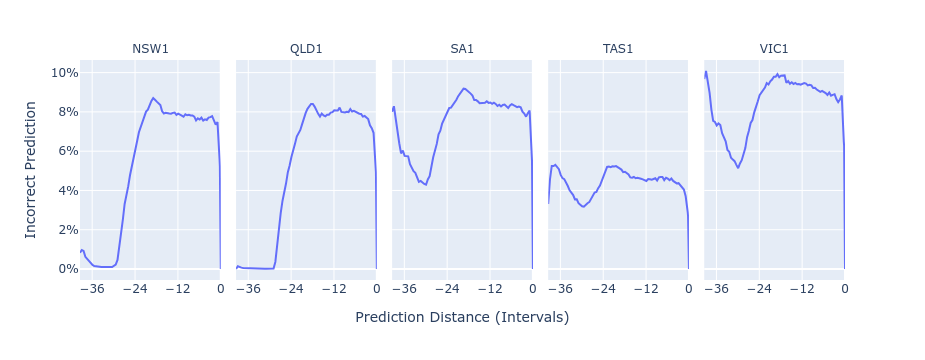

In [59]:
fig = px.line(
    results,
    x='HOURS_BEFORE',
    y="INCORRECT",
    facet_col='REGIONID',
    labels={
        'INTERVALS_BEFORE': 'Prediction Distance (Intervals)',
        'HOURS_BEFORE': 'Prediction Distance (Hours)',
        'CORRECT': 'Correct Prediction',
        'INCORRECT': 'Incorrect Prediction',
    },
    hover_data=['SAMPLE_COUNT', 'SAMPLE_COUNT_LOW', 'SAMPLE_COUNT_HIGH'],
)

for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split("=")[-1]

# stop x axis labels overlapping by only showing for one facet
num_regions = results.select("REGIONID").unique().height
fig.update_xaxes(title_text="")
fig.update_xaxes(title_text="Prediction Distance (Intervals)", col=num_regions // 2 + 1)

# x axis as multiples of 12, because it's in hours
fig.update_xaxes(dtick=12)

fig.update_yaxes(tickformat=".0%")

fig.write_image('results-1.svg')
fig.show()

/tmp/ipykernel_155238/391450481.py:51: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




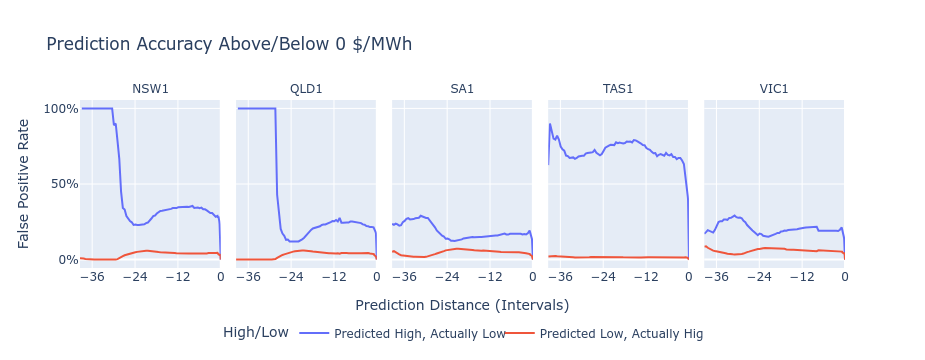

In [60]:
# split up false positive and false negative
# For plotly, we need to melt first

results_melted = (
    results.unpivot(
        index=['REGIONID', 'HOURS_BEFORE', 'INTERVALS_BEFORE'],
        on=['FALSE_HIGH', 'FALSE_LOW'],
        variable_name='DIRECTION',
        value_name='RATE'
    )
    # give them a pretty name
    .with_columns(
        pl.col('DIRECTION').replace({
            'FALSE_HIGH': 'Predicted High, Actually Low',
            'FALSE_LOW': 'Predicted Low, Actually High'
        })
    )
)

fig = px.line(
    results_melted,
    title=f"Prediction Accuracy Above/Below {price_threshold} $/MWh",
    x='HOURS_BEFORE',
    y='RATE',
    color='DIRECTION',
    facet_col='REGIONID',
    labels={
        'INTERVALS_BEFORE': 'Prediction Distance (Intervals)',
        'HOURS_BEFORE': 'Prediction Distance (Hours)',
        'RATE': 'False Positive Rate',
        'DIRECTION': 'High/Low'
    },
)

fig.update_yaxes(tickformat=".0%")

for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split("=")[-1]

# stop x axis labels overlapping by only showing for one facet
num_regions = results.select("REGIONID").unique().height
fig.update_xaxes(title_text="")
fig.update_xaxes(title_text="Prediction Distance (Intervals)", col=num_regions // 2 + 1)

# legend at bottom
fig.update_layout(legend=dict(orientation="h", yanchor="top", y=-0.3, xanchor="center", x=0.5))

# x axis as multiples of 12, because it's in hours
fig.update_xaxes(dtick=12)

fig.write_image('results-2.svg', height=500, width=800)
fig.show()

How to interpret this graph?

The further left you go, the further back in time the predictions are made, relative to the period they are made for.
The lines drop to exactly 0% at x=0, because that means the price for the current interval, which is not a prediction, so is always right. (If you take it from `DISPATCHPRICE`, not `P5MIN_REGIONSOLUTION`.)

Higher values mean predictions are less accurate. Here correctness means being on the correct side of an arbitrary price threshold (which I chose to be 0 $/MWh). 

The blue line is for predictions where AEMO said the price would be above this threshold (i.e. positive), but it was actually below (i.e. negative) in the end. Red is the inverse. 
Specifically, I am conditioning/filtering on the final price being positive/negative, and then checking the predictions within that subset of intervals.

I expected a monotonically decreasing curve. The closer you get to the actual period, the better predictions should be.
For NSW and QLD, we see that the values are all 100% and 0%. This means that for predictions that far out, AEMO never predicts a negative price, which is interesting.

This graph shows that predictions appear to get worse around 24 hours beforehand. I do not know why this is.
